In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

from PIL import Image

# Load Data

In [2]:
train_data = tf.keras.utils.image_dataset_from_directory('Teeth_Dataset/Training')
test_data = tf.keras.utils.image_dataset_from_directory('Teeth_Dataset/Testing')
validation_data = tf.keras.utils.image_dataset_from_directory('Teeth_Dataset/Validation')

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


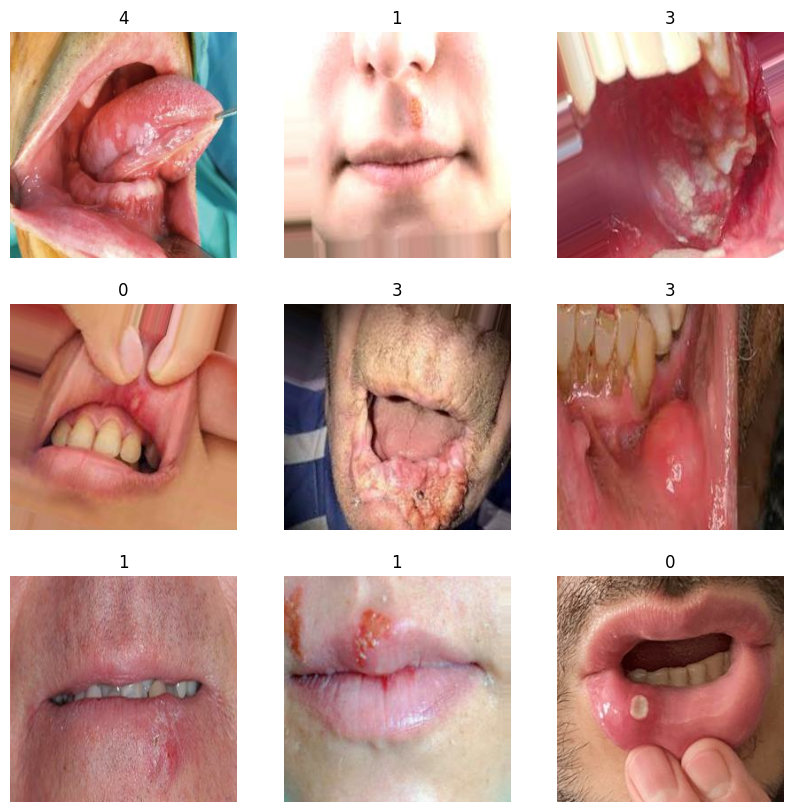

In [47]:
# plot some images from training data
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Data Augmentation 

In [5]:
# Define the data augmentation pipeline
datagen = ImageDataGenerator(
    rescale=1./255,                 # Scale images from [0, 255] to [0, 1]
    rotation_range=20,              # Rotate images by 20%
    width_shift_range=0.1,          # Shift images horizontally by 10%
    height_shift_range=0.1,         # Shift images vertically by 10%
    shear_range=0.2,                # Shear transformation
    zoom_range=0.2,                 # Zoom images by 20%
    horizontal_flip=True,           # Flip images horizontally
    fill_mode='nearest'             # Fill missing pixels after transformation
)

In [13]:
# Directory where augmented images will be saved
base_save_dir = 'Teeth_Dataset/Augmented'

# Ensure base directory exists
os.makedirs(base_save_dir, exist_ok=True)

# Iterate over the original dataset
for images, labels in train_data:
    for img, label in zip(images, labels):
        class_name = train_data.class_names[label.numpy()]  # Get the class name from the label
        save_dir = os.path.join(base_save_dir, class_name)  # Create subdirectory for the class
        os.makedirs(save_dir, exist_ok=True)  # Ensure the subdirectory exists
        
        # Save the augmented images into the class subdirectory
        i = 0
        for batch in datagen.flow(tf.expand_dims(img, 0), batch_size=1, save_to_dir=save_dir, save_prefix='aug', save_format='jpg'):
            i += 1
            if i > 10:  # Limit the number of new images per original image
                break

In [14]:
# load the augmented data
augmented_data = tf.keras.utils.image_dataset_from_directory('Teeth_Dataset/Augmented')

Found 26720 files belonging to 7 classes.


# Scale Data

In [17]:
augmented_data = augmented_data.map(lambda x,y: (x/255, y))
test_data = test_data.map(lambda x,y: (x/255, y))
validation_data = validation_data.map(lambda x,y: (x/255, y))

In [18]:
# check if range is [0, 1]
for images, labels in augmented_data:
    print(images[0].numpy().min(), images[0].numpy().max())
    break

0.0 1.0


In [15]:
# Check for scaling and augmentation
for images, labels in augmented_data:
    print(images.shape, labels.shape)
    break

(32, 256, 256, 3) (32,)


In [19]:
train_data_iterator = augmented_data.as_numpy_iterator()
test_data_iterator = test_data.as_numpy_iterator()
validation_data_iterator =validation_data.as_numpy_iterator()

In [20]:
# Check if it is scaled from 0 to 1
print(train_data_iterator.next()[0].max())
print(train_data_iterator.next()[0].min())


1.0
0.0


In [21]:
batch = train_data_iterator.next()

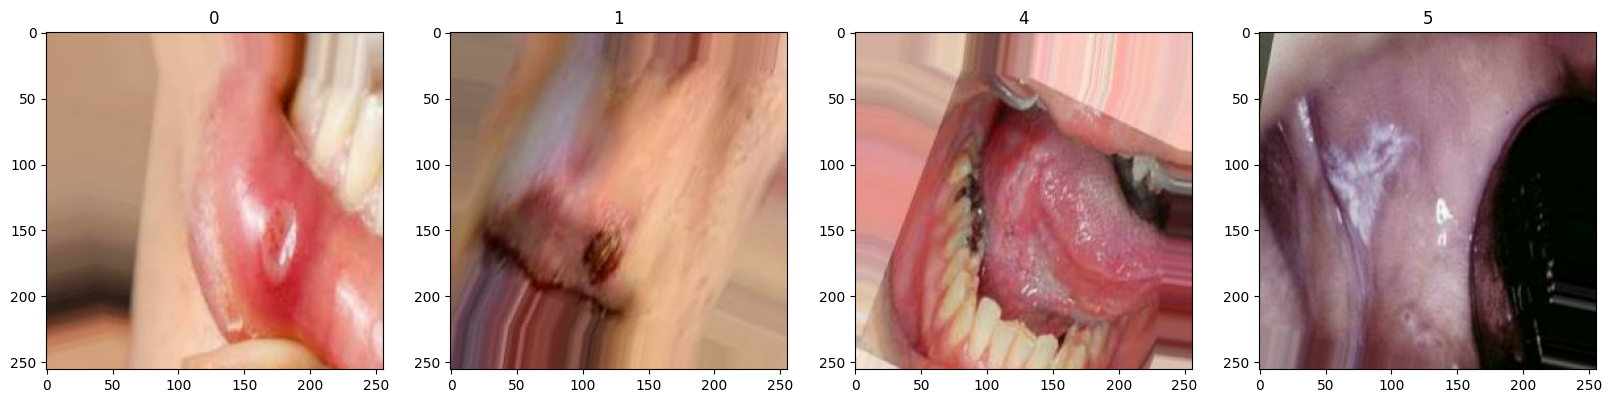

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# Create Model

In [24]:
input_shape = [256,256,3]

# Define the residual block with shortcut matching
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    
    # First convolution layer
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=stride, padding='same', activation='relu')(x)
    
    # Second convolution layer
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    
    # Match the shortcut to the output shape if necessary
    if shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters=filters, kernel_size=1, strides=stride, padding='same')(shortcut)
    
    # Add the shortcut (identity mapping)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

# Input layer
inputs = tf.keras.Input(shape=[256, 256, 3])

# Initial Convolution and MaxPooling
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(7,7), strides=2, padding='same', activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# Residual Blocks
x = residual_block(x, filters=16)
x = residual_block(x, filters=32)
x = residual_block(x, filters=64)

# Global Average Pooling replaces Flatten
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Fully Connected Layer
x = tf.keras.layers.Dense(units=256, activation='relu')(x)

# Output Layer
outputs = tf.keras.layers.Dense(units=7, activation='softmax')(x)

# Create the model
Teeth_Disease = tf.keras.Model(inputs=inputs, outputs=outputs)

In [25]:
Teeth_Disease.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │      2,368 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │      2,320 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │      2,320 │ conv2d_6[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 64,    │          0 │ conv2d_7[0][0],   │
│                     │ 16)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ add_2[0][0]       │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │      4,640 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_8[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │        544 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 64, 64,    │          0 │ conv2d_9[0][0],   │
│                     │ 32)               │            │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ add_3[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │     18,496 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_11[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │      2,112 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 64, 64,    │          0 │ conv2d_12[0][0],  │
│                     │ 64)               │            │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ add_4[0][0]     

 Total params: 97,415 (380.53 KB)

 Trainable params: 97,415 (380.53 KB)

 Non-trainable params: 0 (0.00 B)

# Compile Model

In [26]:
Teeth_Disease.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [34]:
batch_size = 32

# Calculate steps per epoch
train_steps = len(augmented_data) // batch_size
val_steps = len(validation_data) // batch_size



model_history = Teeth_Disease.fit(
                              augmented_data,
                              validation_data=validation_data,
                              epochs=200,
                              steps_per_epoch=train_steps,
                              validation_steps=val_steps,
                                )

Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 469ms/step - accuracy: 0.4300 - loss: 1.4567 - val_accuracy: 0.5000 - val_loss: 1.4159
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 473ms/step - accuracy: 0.4018 - loss: 1.4626 - val_accuracy: 0.4062 - val_loss: 1.4789
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 467ms/step - accuracy: 0.4240 - loss: 1.4783 - val_accuracy: 0.4375 - val_loss: 1.5091
Epoch 4/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 437ms/step - accuracy: 0.4127 - loss: 1.5118 - val_accuracy: 0.4688 - val_loss: 1.3676
Epoch 5/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 503ms/step - accuracy: 0.4665 - loss: 1.3936 - val_accuracy: 0.5000 - val_loss: 1.6133
Epoch 6/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 530ms/step - accuracy: 0.4308 - loss: 1.4418 - val_accuracy: 0.3750 - val_loss: 1.3500
Epoch 7/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 494ms/step - accuracy: 0.4250 - loss: 1.3910 - val_accuracy: 0.4375 - val_loss: 1.3161
Epoch 8/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 491ms/step - accuracy: 0.4695 - loss: 1.4230 - 

# Plot Data

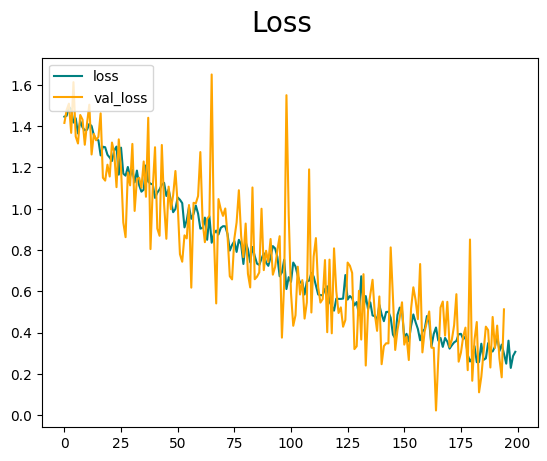

In [35]:
fig = plt.figure()
plt.plot(model_history.history['loss'], color='teal', label='loss')
plt.plot(model_history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

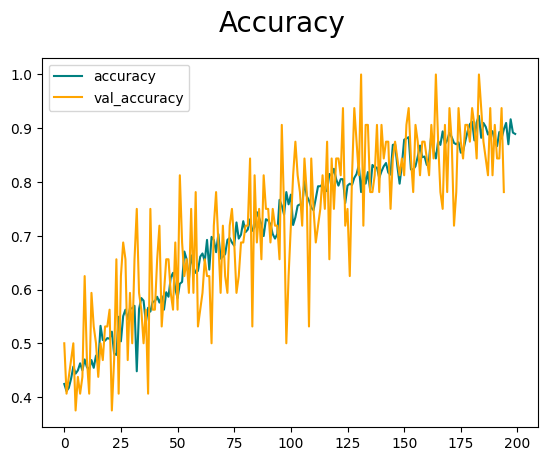

In [36]:
fig = plt.figure()
plt.plot(model_history.history['accuracy'], color='teal', label='accuracy')
plt.plot(model_history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

As you can see from both graphs there is high variability and spikes which can indicate that model maybe be overfitting or there is noise in data 
But the validation loss does decrease overall the model is still improving, but the training may benefit from further tuning 

# Evaluation

In [37]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = Teeth_Disease.evaluate(test_data)

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.8707 - loss: 0.3580


# Save Model

In [41]:
# Save the model
Teeth_Disease.save('Teeth_Disease.h5')

In [43]:
# Save the model in the native Keras format
Teeth_Disease.save('Teeth_Disease_Model.keras')

In [42]:
import pickle
#Save the training history
with open('Teeth_Disease_History.pkl', 'wb') as f:
    pickle.dump(model_history.history, f)

In [45]:
# Save the preprocessing configuration
with open('preprocessing_config.pkl', 'wb') as f:
    pickle.dump({
        'rescale': 1./255,
        'rotation_range': 20,
        'width_shift_range': 0.1,
        'height_shift_range': 0.1,
        'shear_range': 0.2,
        'zoom_range': 0.2,
        'horizontal_flip': True,
        'fill_mode': 'nearest'
    }, f)

In [46]:
# Load the augmented data
augmented_data = tf.keras.utils.image_dataset_from_directory(
    'Teeth_Dataset/Augmented',
    image_size=(256, 256),  # Use the same size as your model input
    batch_size=32,
    label_mode='int'
)

augmented_data = augmented_data.map(lambda x, y: (x / 255, y))

# Save the augmented data pipeline configuration
pipeline_config = {
    'image_size': (256, 256),
    'batch_size': 32
}

with open('augmented_data_pipeline_config.pkl', 'wb') as f:
    pickle.dump(pipeline_config, f)

Found 26720 files belonging to 7 classes.
